In [1]:
import pandas as pd
from datetime import datetime
import psutil
import os
import gc

from sdv.datasets.local import load_csvs
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.single_table import CTGANSynthesizer
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic

# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')
# %matplotlib inline: only draw static
# images in the notebook
%matplotlib inline

C:\Users\m033\Anaconda3\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(
C:\Users\m033\Anaconda3\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (3.0.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn(


# Global settings

In [2]:

pd.set_option('max_row', None)
#pd.options.display.max_rows = 1000

# Set a value for the home folder.
home_folder = "."

# Set values for the various paths.
input_path = home_folder + "\data"

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')
os.path.abspath(os.getcwd())

2024-08-05 22:17:06.760729
svmem(total=16756752384, available=4645416960, percent=72.3, used=12111335424, free=4645416960)


'C:\\Users\\m033\\OneDrive - GWLE\\Documents\\GitHub\\Data-Science-Thesis'

# Use SDV - Synthetic Data Vault
This is a Python package to generate synthetic data based on the dataset provided. The generated data could be single-table, multi-table, or time-series, depending on the scheme provided in the environment. Also, the generated data would have the same format properties and statistics as the provided dataset.¶

SDV generates synthetic data by applying mathematical techniques and machine learning models such as the deep learning model. Even if the data contain multiple data types and missing data, SDV will handle it, so we only need to provide the data (and the metadata when required).¶

The SDV creates synthetic data using machine learning. A synthesizer is an object that you can use to accomplish this task.¶
1.  You'll start by creating a synthesizer based on your metadata
2.  Next, you'll train the synthesizer using real data. In this phase, the synthesizer will learn patterns from the real data.
3.  Once your synthesizer is trained, you can use it to generate new, synthetic data.

Of the original data, only the contract number needs to synthesised as everything else is either a boolean that already has obfuscated the fund data or is a calculation based on PII data with the PII data removed.

https://docs.sdv.dev/sdv/single-table-data/data-preparation/single-table-metadata-api

# 1. Read back the first half of the full set of data.  There are 6,186,149 records so this tranche will synthesise the first 3,100,000.

# The next tranche will synthesise 3,086,149.

# This is done to reduce a memory constraint on the runtime environment, which cannot be virtualised because of the sensitive nature of the data.

In [3]:
# giving directory name
filename = input_path + '\Full_Population_With_Market_Index_Data.csv'

df_Switches_tranche_1 = pd.read_csv(filename,dtype = {'ContractNumber': str,
                                           'ProdCat': str,
                                           'ProdCode': str,
                                           'PolicyStatus': str,
                                           'Switch_Flag': bool,
                                           'ServicingBroker': str,
                                           'InitialBroker': str,
                                           'BrokerCategory': str,
                                           'Policy_Fee_Type_Desc': str,      
                                           'PricingVariant': int,
                                           'PayFreq': int,
                                           'VIPType': str,
                                          'Nationality': str,
#                                          'IsSmoker': bool,
                                          'IsSmoker': str,
                                          'PoliticallyExposed': str,
                                          'BirthPlace': str,
                                          'Gender': str,
                                          'MaritalStatus': str,
                                          'AddressCity': str,
                                          'PartnerType': str,
                                          'EUSanctioned': str,
#                                          'EUSanctioned': bool,
                                          'AddressDistrict': str,
                                          'Postal_Code_Name': str,
                                          'District': str,
                                          'State': str,
                                          'VN_MILIEU_CODE': str,
                                          'VN_TARGET_GROUP_CODE': str,
                                          'VN_MILIEU_DESCRIPTION': str,
                                          'VP_MILIEU_DESCRIPTION': str,  
# Tranche 1.
                                          'AnniversaryMth': int},low_memory=False, header=0, nrows=3100000)
# Tranche 2.                              'AnniversaryMth': int},low_memory=False, header=0, nrows=3086149)

# Fill NULLs
df_Switches_tranche_1 = df_Switches_tranche_1.fillna(0)

# Track runtime and encironment.
print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# print stats.
print(len(df_Switches_tranche_1.index))
print(df_Switches_tranche_1.dtypes)

# Turn off dislays to protect PII
#df_Switches_tranche_1.head(10)

2024-08-05 22:18:33.342376
svmem(total=16756752384, available=5896814592, percent=64.8, used=10859937792, free=5896814592)
3100000
ContractNumber            object
Switch_Flag                 bool
SnapshotDt                object
Term_Passed              float64
Term_Remaining           float64
TermRemainingLTEQ_5        int64
TermRemainingLTEQ_10       int64
Age                      float64
AnniversaryMth             int32
ProdCat                   object
ProdCode                  object
PolicyStatus              object
PolicyFeeType             object
PricingVariant             int32
PayFreq                    int32
IndexationPercent          int64
Premium                  float64
PremiumCalcMethod         object
ServicingBroker           object
InitialBroker             object
BrokerCategory            object
InitialRate              float64
RenewalRate              float64
VIPType                   object
Nationality               object
IsSmoker                  object
Politically

In [4]:
df_Switches_table = df_Switches_tranche_1[['ContractNumber','Switch_Flag','Term_Passed','Term_Remaining','TermRemainingLTEQ_5',
                                       'TermRemainingLTEQ_10','Age','AnniversaryMth','ProdCat','ProdCode','PolicyStatus',
                                       'SnapshotDt','PolicyFeeType','PricingVariant','PayFreq','IndexationPercent',
                                       'Premium','PremiumCalcMethod','ServicingBroker','InitialBroker','BrokerCategory',
                                       'InitialRate','RenewalRate','VIPType','Nationality','IsSmoker','PoliticallyExposed',
                                       'BirthPlace','Gender','MaritalStatus','PensionDisability','WOPDisability',
                                       'AddressCity','PartnerType','EUSanctioned','AddressDistrict','Postal_Code',
                                       'Postal_Code_Name','District','State','VN_MILIEU_CODE','VN_TARGET_GROUP_CODE',
                                       'VN_MILIEU_DESCRIPTION','VP_MILIEU_DESCRIPTION','Term']]

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

# print stats.
print(len(df_Switches_tranche_1.index))
del df_Switches_tranche_1

print(len(df_Switches_table.index))

# Turn off dislays to protect PII
#df_Switches_table.head(10)

2024-08-05 22:18:35.384662
svmem(total=16756752384, available=4819005440, percent=71.2, used=11937746944, free=4819005440)
3100000
3100000


 # Look at the distribution of the target variable.

In [5]:
print(df_Switches_table.Switch_Flag.value_counts(normalize=True))

False    0.999331
True     0.000669
Name: Switch_Flag, dtype: float64


False    0.999331
True     0.000669
Name: Switch_Flag, dtype: float64


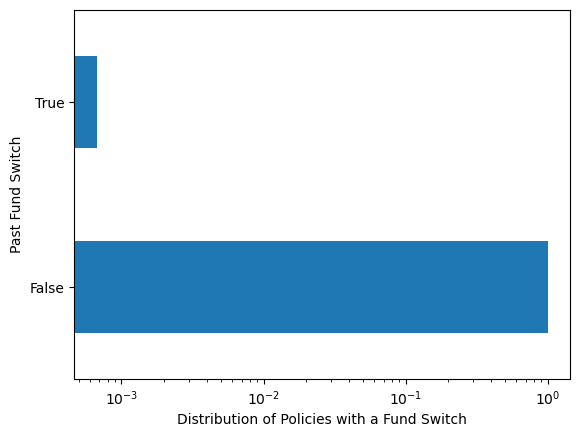

In [6]:
# Count and print the values. 
print(df_Switches_table.Switch_Flag.value_counts(normalize=True))

# plot value_counts of Series
ax = df_Switches_table['Switch_Flag'].value_counts(normalize=True).plot(kind='barh')

# Set axis headings.
ax.set(xlabel='Distribution of Policies with a Fund Switch', ylabel='Past Fund Switch')
ax.set_xscale('log')

ax.figure.savefig('Distribution of Policies with a Fund Switch.png')  # saves the current figure

# 2. Generate single table metadata from the dataframe.

In [7]:
metadata = SingleTableMetadata()

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

#metadata
print("metadata-",metadata) 

2024-08-05 22:18:36.833071
svmem(total=16756752384, available=6128754688, percent=63.4, used=10627997696, free=6128754688)
metadata- {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}


# 3. Auto detect metadata.
## The real fund switch data comes with no pre-prepared metadata automatically detect and generate the metadata based on the real data. 


In [8]:
metadata.detect_from_dataframe(data=df_Switches_table)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')


#metadata
print("metadata-",metadata) 
metadata

2024-08-05 22:18:41.246544
svmem(total=16756752384, available=6095409152, percent=63.6, used=10661343232, free=6095409152)
metadata- {
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "Sna

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "SnapshotDt": {
            "sdtype": "categorical"
        },
        "PolicyFeeType": {
            "sdtype": "categorical"
        },


In [9]:
metadata.update_column(
    column_name='SnapshotDt',
    sdtype='datetime',
    datetime_format='%Y-%m-%d')

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

metadata

2024-08-05 22:18:41.266126
svmem(total=16756752384, available=6095462400, percent=63.6, used=10661289984, free=6095462400)


{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "SnapshotDt": {
            "sdtype": "datetime",
            "datetime_format": "%Y-%m-%d"
        },
        "PolicyFeeType": {
       

# Create a synthesizer
## Set enforce_min_max_values to ensure the synthetic data adheres to the min/max boundaries set by the real data.
## Use enforce_rounding to ensure rounding is not enforced.  The Age column is not rounded.

In [10]:
synthesizer = GaussianCopulaSynthesizer(
    metadata, # required
    enforce_min_max_values=True,
    enforce_rounding=False,
    numerical_distributions={
        'PricingVariant': 'norm',
        'IndexationPercent': 'norm',
        'Premium': 'norm',
        'InitialRate': 'norm',
        'RenewalRate': 'norm',
        'PayFreq': 'norm'
    },
    default_distribution='norm'
)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-08-05 22:18:41.285792
svmem(total=16756752384, available=6095380480, percent=63.6, used=10661371904, free=6095380480)


C:\Users\m033\Anaconda3\lib\site-packages\rdt\transformers\base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


### View all parameters used by the synthesizer, mine and the default ones.

In [11]:
parameters=synthesizer.get_parameters()
parameters


print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-08-05 22:18:41.304261
svmem(total=16756752384, available=6095536128, percent=63.6, used=10661216256, free=6095536128)


### View the metadata objects included for the synthesizer

In [22]:
metadata = synthesizer.get_metadata()
metadata

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

{
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1",
    "columns": {
        "ContractNumber": {
            "sdtype": "categorical"
        },
        "Switch_Flag": {
            "sdtype": "boolean"
        },
        "Term_Passed": {
            "sdtype": "numerical"
        },
        "Term_Remaining": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_5": {
            "sdtype": "numerical"
        },
        "TermRemainingLTEQ_10": {
            "sdtype": "numerical"
        },
        "Age": {
            "sdtype": "numerical"
        },
        "AnniversaryMth": {
            "sdtype": "numerical"
        },
        "ProdCat": {
            "sdtype": "categorical"
        },
        "ProdCode": {
            "sdtype": "categorical"
        },
        "PolicyStatus": {
            "sdtype": "categorical"
        },
        "SnapshotDt": {
            "sdtype": "datetime",
            "datetime_format": "%Y-%m-%d"
        },
        "PolicyFeeType": {
       

## Use the fit method to train an ML model on the data. 
### The synthesizer uses Gaussian Copulas to learn  distribution of the real data. This happens in two stages.  It learns the distribution of each individual column (the marginal distribution)

In [23]:
synthesizer.fit(df_Switches_table)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

## The get_learned_distributions shows  the marginal distributions learned by teh model to estimate the shape of each column.  It outputs a dictionary that maps the name of each learned column to the distribution that estimates its shape.

In [24]:
synthesizer.get_learned_distributions()

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-07-26 21:43:54.778966
svmem(total=16756752384, available=10078834688, percent=39.9, used=6677917696, free=10078834688)


## Save the synthesizer as a pickle file to use on the real data, to generate synthetic data.

In [25]:
synthesizer.save(
    filepath=home_folder + '\switch_data_synthesizer.pkl'
)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-07-26 21:43:55.064299
svmem(total=16756752384, available=10033778688, percent=40.1, used=6722973696, free=10033778688)


## Now reload this synthesiser from teh pickle file to use on the real data.

In [31]:
synthesizer = GaussianCopulaSynthesizer.load(
    filepath=home_folder + '\switch_data_synthesizer.pkl'
)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

2024-07-26 22:48:51.561830
svmem(total=16756752384, available=11960406016, percent=28.6, used=4796346368, free=11960406016)


## Create the synthetic data from the synthesiser.

In [32]:
synthetic_data = synthesizer.sample(num_rows=3100000)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

#synthetic_data
print("synthetic_data-",synthetic_data) 

2024-07-26 22:55:47.268118
svmem(total=16756752384, available=9934585856, percent=40.7, used=6822166528, free=9934585856)
synthetic_data- 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## Save the syntheised data to file.

In [33]:
# save the data as a CSV
synthetic_data.to_csv('data/synthetic_data_tranche1.csv', index=False)

print('==========================')
now = datetime.now()
print(now)
print('==========================')
print(psutil.virtual_memory())
print('==========================')

print(len(synthetic_data.index))

2024-07-26 23:09:20.765272
svmem(total=16756752384, available=11413663744, percent=31.9, used=5343088640, free=11413663744)
3100000


In [34]:
print(len(synthetic_data.index))

3100000


In [35]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
df_Switches_table   DataFrame            ContractNumber  S<...>100000 rows x 45 columns]
synthetic_data      DataFrame            ContractNumber  S<...>100000 rows x 45 columns]


In [36]:
del df_Switches_table

## Create a Python dictionary that corresponds to the metadata.

In [37]:
python_dict = metadata.to_dict()
python_dict

{'METADATA_SPEC_VERSION': 'SINGLE_TABLE_V1',
 'columns': {'ContractNumber': {'sdtype': 'categorical'},
  'Switch_Flag': {'sdtype': 'boolean'},
  'Term_Passed': {'sdtype': 'numerical'},
  'Term_Remaining': {'sdtype': 'numerical'},
  'TermRemainingLTEQ_5': {'sdtype': 'numerical'},
  'TermRemainingLTEQ_10': {'sdtype': 'numerical'},
  'Age': {'sdtype': 'numerical'},
  'AnniversaryMth': {'sdtype': 'numerical'},
  'ProdCat': {'sdtype': 'categorical'},
  'ProdCode': {'sdtype': 'categorical'},
  'PolicyStatus': {'sdtype': 'categorical'},
  'SnapshotDt': {'sdtype': 'datetime', 'datetime_format': '%Y-%m-%d'},
  'PolicyFeeType': {'sdtype': 'categorical'},
  'PricingVariant': {'sdtype': 'numerical'},
  'PayFreq': {'sdtype': 'numerical'},
  'IndexationPercent': {'sdtype': 'numerical'},
  'Premium': {'sdtype': 'numerical'},
  'PremiumCalcMethod': {'sdtype': 'categorical'},
  'ServicingBroker': {'sdtype': 'categorical'},
  'InitialBroker': {'sdtype': 'categorical'},
  'BrokerCategory': {'sdtype': 'ca

In [62]:
%whos DataFrame

Variable         Type         Data/Info
---------------------------------------
Switches_table   DataFrame              POL_NUMB  API_T<...>[102975 rows x 4 columns]
synthetic_data   DataFrame          POL_NUMB           <...>18527.459563     202205  


In [63]:
psutil.virtual_memory().available * 100 / psutil.virtual_memory().total

27.75071840555521